In [1]:
import numpy as np
import queue
import math
from pylab import *
class traffic_game():
    def __init__(self, N, f, M, AVG, VAR):
        self.N = N
        self.f = f
        self.M = M
        self.AVG = AVG
        self.VAR = VAR
        self.theta =  np.minimum(np.maximum(np.random.normal(self.AVG,self.VAR,self.N),0.2),0.8)
#         self.t = np.random.uniform(0,self.theta, self.N)
        self.t = self.theta - 0.2
    
    def updateNf(self, N, f):
        self.N = N
        self.f = f
        
    def init_t(self):
        self.t = self.theta - 0.2
        
    def runs(self, t):
        finished_t = np.zeros(self.N)
        queuing_n = 1
        finished = 0
        sorted_t = np.sort(t)
        index = np.argsort(t)
        q = queue.Queue()
        current = sorted_t[0]
        q.put(index[0])
        x = [0,current, current]
        y = [0,0,1]
        while finished < self.N:
            if q.qsize() > 0:
                current += 1/self.f
                finished += 1
                finished_t[q.get()] = current
                for i in range(queuing_n,self.N):
                    if sorted_t[i] <= current:
                        q.put(index[i])
                        queuing_n += 1
                x.append(current)
                y.append(q.qsize())
            else:
                x.append(current)
                y.append(q.qsize())
                if queuing_n >= self.N:
                    break
                current = sorted_t[queuing_n]
                q.put(index[queuing_n])
                queuing_n += 1
                x.append(current)
                y.append(q.qsize())
        return x,y,finished_t
    
    def compute_optimal(self):
        epsilon = 0.001
        opt = np.zeros(len(self.t))
        for i in range(len(opt)):
            c = self.t.copy()
            a = 0
            b = 1
            while b-a > epsilon:
                c[i] = (a+b)/2
                x,y,finish = self.runs(c)
                if finish[i]>self.theta[i]:
                    b = (a+b)/2
                else:
                    a = (a+b)/2
            opt[i] = (a+b)/2
        return self.theta - opt
    
    def cost(self, step):
        epsilon = 0.01
        x,y,ft = self.runs(self.t)
        aot = self.theta - self.t
        faot = self.theta - ft
        cost = aot * (faot>=0) + (faot < 0)*self.M
        update = faot/(step+1)*(faot>epsilon) + (faot<0)*faot + (faot < epsilon)*(faot - epsilon)/(step+1)
        return cost, update
    
    def update(self, gradient):
        self.t = np.minimum(np.maximum(self.t + gradient,0),1)
        
    def info(self):
        return self.theta, self.t
    

In [125]:
import numpy as np
import queue
import math
from pylab import *
import random
class detour_game():
    def __init__(self, N, f, arr):
        self.N = N # number of stations
        self.f = f
        self.arr = arr
        self.interval = 0.001
        self.queue = []
        self.strategy = np.ones([4,N])
        self.strategy[3][0] = 0
        self.current = 0
        self.train = []
        self.total = 0
        self.finish = 0
        self.time = 0
        self.update_cache = np.zeros([4,N])
        self.update_cache_num = np.zeros([4,N])
        self.update_num = 0
        for i in range(self.N):
            self.queue.append([])
            self.train.append([0,0,0,0])
            
    def step(self):
        arr_prob = self.arr * self.interval
        t = self.current
        for i in range(int(1/(self.f*self.interval))):
            self.current += self.interval
            r = random.uniform(0,1)
            if r < arr_prob:
                self.total += 1
                length = len(self.queue[0])
                r = random.uniform(0,1)*self.strategy[length].sum()
                for i in range(self.N):
                    if r >= self.strategy[length][i]:
                        r -= self.strategy[length][i]
                    else:
                        self.queue[i].append([self.current,length,i])
                        break
        self.current = t + 1/self.f
        for i in range(self.N):
            if self.train[i][0] != 0:
                continue
            if self.train[i][0] == 0 and len(self.queue[i]) > 0:
                if self.current >= self.queue[i][0][0] + i: # in-queue time
                    self.train[i][0] = self.queue[i][0][0] # join time
                    self.train[i][1] = self.current + i # finish time
                    self.train[i][2] = self.queue[i][0][1] # strategy:length
                    self.train[i][3] = self.queue[i][0][2] # strategy:station
                    self.queue[i] = self.queue[i][1:]
        start = self.train[0][0]
        finish = self.train[0][1]
        strategy_length = self.train[0][2]
        strategy_station = self.train[0][3]
        if start != 0:
#             print("start, finish", self.train[0])
            self.train = self.train[1:]
            self.train.append([0,0,0,0])
            self.finish += 1
            self.time += finish - start
            self.update_cache[strategy_length][strategy_station] += finish - start
            self.update_cache_num[strategy_length][strategy_station] += 1
            self.update_num += 1
        return start, finish
    
    def update(self):
        avg = self.time/self.update_num
#         print(avg)
        epsilon = 0.1
        for i in range(4):
            for j in range(self.N):
                if self.update_cache[i][j] != 0:
                    c = self.update_cache[i][j] / self.update_cache_num[i][j] - avg
                    self.update_cache[i][j] = 0
                    self.update_cache_num[i][j] = 0
                    self.strategy[i][j] *= pow((1-epsilon),c)
        return avg        
                    
    def print_prob(self):
        print("prob:", self.strategy[0]/self.strategy[0].sum())
        print("prob:", self.strategy[1]/self.strategy[1].sum())
        print("prob:", self.strategy[2]/self.strategy[2].sum())
        print("prob:", self.strategy[3]/self.strategy[3].sum())
    
    def print_queue(self):
        print("queue length:")
        for i in range(self.N):
            print(len(self.queue[i]))
        print("queue",self.queue)
                    

In [148]:
import seaborn as sns
def visualize(x,y,path = None, marksize = None, xl = None, yl = None,mode = None, e = None):
#     plt.plot(x, y, 'ro-', color='#4169E1', alpha=0.8, linewidth=1)
    if mode == "variance":
        plt.figure(figsize=(6.4,4.8), dpi=200)
        sns.tsplot(time=x, data=y, color = 'b', linestyle='-')
        return
    if mode == "errorbar":
        plt.figure(figsize=(6.4,4.8), dpi=200)
        plt.errorbar(x, y, yerr = e, linestyle='-', marker = 'o',markersize= marksize)
    if mode == "exhibit":
        plt.figure(figsize=(6.4,4.8), dpi=200)
    if marksize != None:
        plt.plot(x, y, 'ro-',markersize = marksize, color='#4169E1', alpha=0.8, linewidth=1)
    else:
        plt.plot(x, y, color='#4169E1', alpha=0.8, linewidth=1)
    if xl != None:
        plt.xlabel(xl)
    if yl != None:
        plt.ylabel(yl)
    if path != None:
        plt.savefig(path)
    plt.show()
    

In [ ]:
game = traffic_game(10,20,1,0.6,0.2)

In [62]:
game.init_t()
game.updateNf(10,20)
NUM_DAYS = 50000
c = []
cmin = 100
nsmin = 100
ns = []
for i in range(NUM_DAYS):
    cost, gradient = game.cost(i)
    c.append(cost.sum())
#     opt = game.compute_optimal()
#     ns.append(np.array(cost - opt).mean())
#     if nsmin > np.array(cost - opt).mean():
#         nsmin = np.array(cost - opt).mean()
#     if np.array(cost - opt).mean() < 0.01 and i > 500:
#         cmin = cost.sum()
#         break
    game.update(gradient)
    

z = []
for i in range(99,len(c)):
    d = np.array(c[max(0,i-99):i+1]).mean()
    c[i] = d
#     e = np.array(ns[max(0,i-99):i+1]).mean()
#     ns[i] = e
    z.append(i)
c = c[99:]
# ns = ns[99:]
visualize(z,c, path = "cost-10-20",xl = "time", yl = "total cost")
# visualize(z,ns, path =  "ns-10-20")
print(nsmin, cmin)

NameError: name 'game' is not defined

In [ ]:
A = [0.020760800331742334,6.432926694726417,
0.04984237751605082,4.409900007553357,
0.053306606908104695,3.2870036499994195,
0.05717800187071215,1.953945910838343,
0.046212693613777917,1.709640805643348,
0.041839820852133294,1.4203379803157383,
0.034647431428984556,1.029301896936245,
0.028524086195147003,0.8436581565378389,
0.026205930898266856,0.758620404098423,
0.022780825358147447,0.7107590597221061,
0.020260731417839302,0.6360897495493074]
z = []
y = []
x = [1.2, 1.4, 1.6, 1.9,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
for i in range(len(A)):
    if i % 2 == 0:
        z.append(A[i])
    if i % 2 == 1:
        y.append(A[i])
        index += 2
visualize(x,y,"./Figure/cost",marksize = 6, xl = "f/N", yl = "total cost",mode="exhibit")
visualize(x,z,"./Figure/epsilon",marksize = 6, xl = "f/N", yl = "epsilon")

In [ ]:
theta, t = game.info()
print(cost)
print(theta)
print(t)

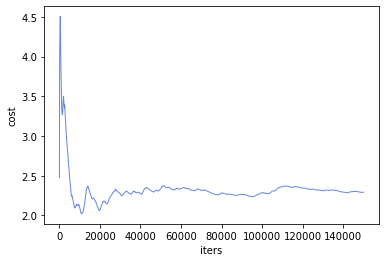

2.2930332432469327


In [219]:
detour = detour_game(N = 5, f = 20, arr = 19.5)
MAX_DAYS = 150000
last_avg = 0
avg = []
x = []
for i in range(MAX_DAYS):
    detour.step()
    if i % 100 == 99:
        avg.append(detour.update())
        x.append(i)
visualize(x,avg,"./Figure/detour_converge", xl = "iters",yl = "cost")
print(avg[-1])
#         if abs(avg - last_avg)<0.0001 and i >= MAX_DAYS/2:
#             break

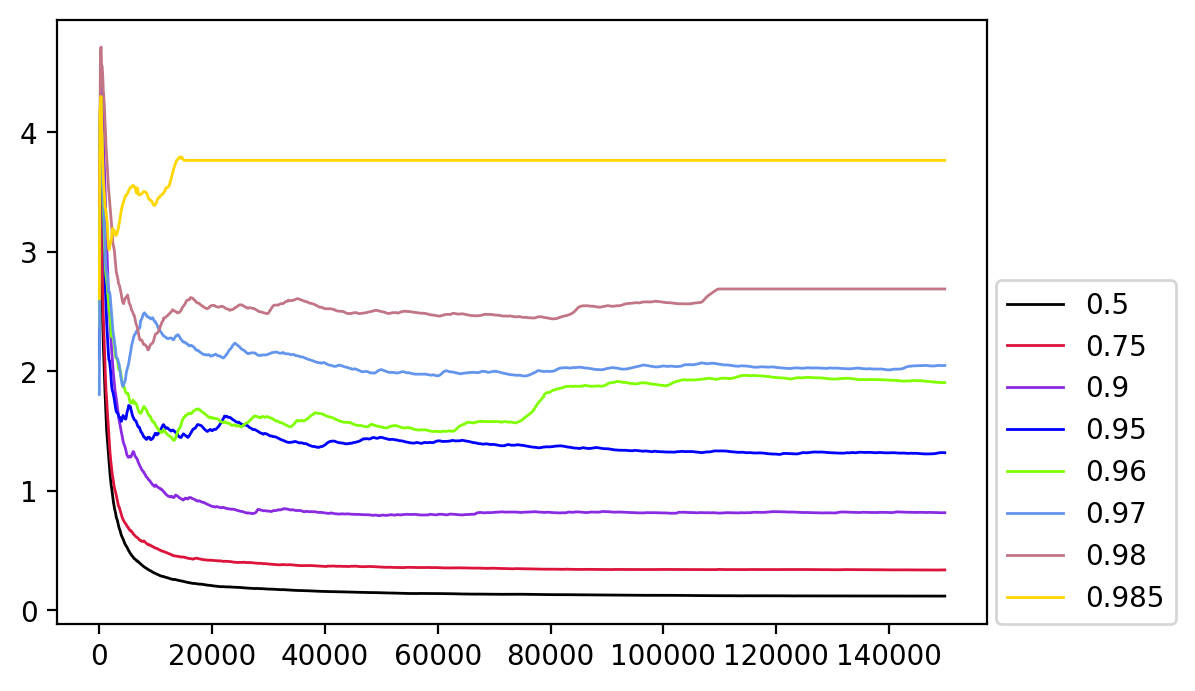

In [226]:
x = [0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.985]
t = []
color = ["#000000","#dc143c","#8a2be2","#0000ff","#7fff00","#6495ed", "#c17585","#ffd700"]
for i in range(1500):
    t.append(i*100)
plt.figure(dpi = 200)
for i in range(8):
    plt.plot(t,data[i],color = color[i],markersize = 2,linestyle = '-',linewidth = 1,label = str(x[i]))
plt.legend(loc = [1.01,0])
plt.savefig("convergence-detour",bbox_inches = 'tight')
plt.show()

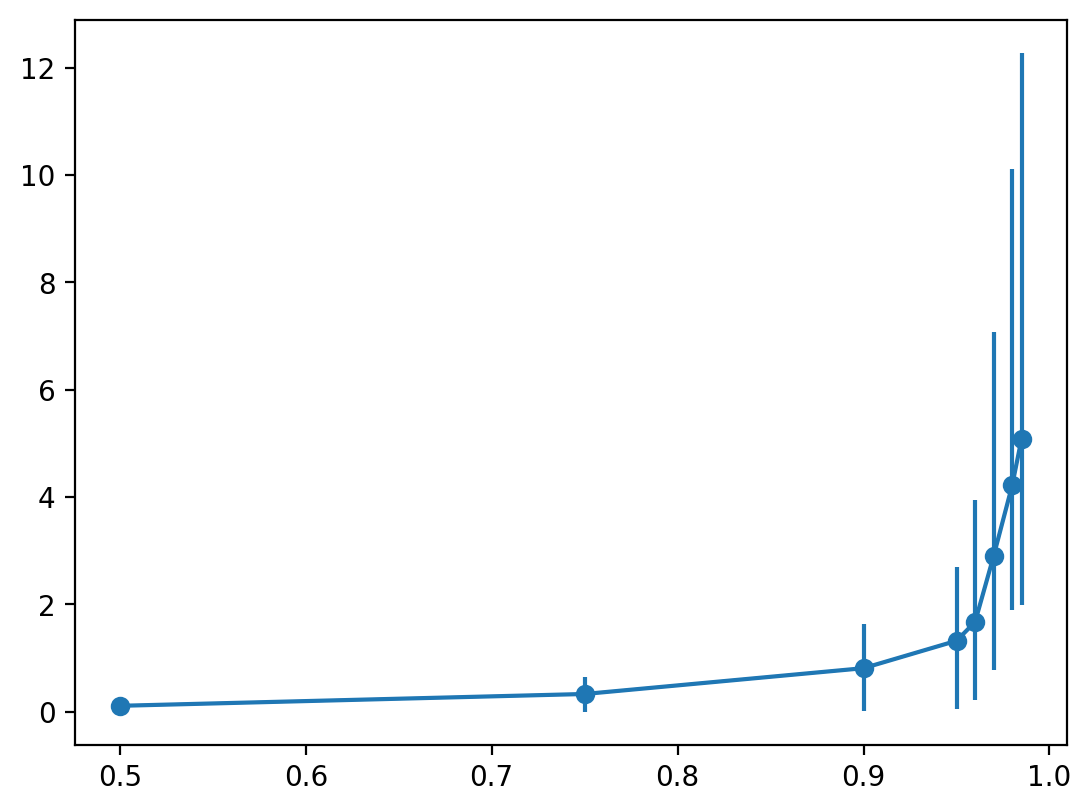

In [215]:
x = [0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.985]
y = [0.10877582124855843, 
     0.32915143957671905, 
     0.8102963940999808, 
     [1.2779864049312606,1.3832654262879818,1.290588007959252,1.3320500437760132], 
     [1.5799234180956643,2.272176456925844,1.4496030454085198,1.5643838469518998,1.4965766456506568], 
     [2.138888277477743, 4.173665624661574,2.507514897726114,3.2144928134239144,2.4844746410044762],
     [5.893126737968775, 2.323613855162155, 2.872797224262428, 4.474099486549598, 5.805781233946831,4.00084847553217],
     [7.191439971384041, 6.41126235276192, 5.02879754873285, 5.436297341737506, 3.3765437554572983, 3.0947130422232085]]

ymean = [0.10877582124855843, 
     0.32915143957671905, 
     0.8102963940999808, 1.32097, 1.6725, 2.9058, 4.2282, 5.0898]
lower = [0.108,0.328,0.805,1.278,1.4496,2.1388, 2.326, 3.0947]
upper = [0.109,0.323,0.815,1.3832,2.272,4.17366,5.893,7.1914]
error = [lower,upper]
# plt.errorbar(x, ymean, yerr=error, fmt='o')
# plt.show()
visualize(x,ymean,path = "./Figure/fancy", mode = "errorbar", e = error)

In [220]:
detour.print_prob()

prob: [1.00000000e+00 2.02781792e-62 4.74146796e-63 1.67087679e-63
 1.00260251e-63]
prob: [9.99999651e-01 3.09909650e-07 2.30441799e-08 1.00746032e-08
 6.00807299e-09]
prob: [9.46212615e-05 9.99084088e-01 4.62326893e-04 1.98763152e-04
 1.60200252e-04]
prob: [0.         0.98906821 0.00695806 0.00261735 0.00135637]


In [90]:
detour.print_queue()

queue length:
2
6173
7
0
0
queue [[[4920.193000009142, 0, 0], [4946.822000009235, 1, 0]], [[4681.959000008269, 0, 1], [4682.0650000082705, 0, 1], [4682.175000008273, 0, 1], [4682.236000008275, 0, 1], [4682.265000008271, 0, 1], [4682.291000008277, 0, 1], [4682.351000008269, 0, 1], [4682.547000008279, 0, 1], [4682.587000008277, 0, 1], [4682.617000008273, 0, 1], [4682.622000008274, 0, 1], [4682.643000008278, 0, 1], [4682.65000000828, 0, 1], [4682.655000008271, 0, 1], [4682.687000008277, 0, 1], [4682.733000008277, 0, 1], [4682.909000008272, 0, 1], [4682.950000008281, 0, 1], [4682.975000008276, 0, 1], [4683.007000008272, 0, 1], [4683.108000008273, 0, 1], [4683.110000008273, 0, 1], [4683.119000008275, 0, 1], [4683.1500000082815, 0, 1], [4683.218000008275, 0, 1], [4683.24300000828, 0, 1], [4683.278000008278, 0, 1], [4683.281000008278, 0, 1], [4683.285000008279, 0, 1], [4683.343000008281, 0, 1], [4683.374000008277, 0, 1], [4683.43800000828, 0, 1], [4683.554000008274, 0, 1], [4683.559000008275,